In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.colors as clrs
plt.rcParams.update({"text.usetex": True})

import math as mt
import energyflow as ef

import modplot

## Load Datasets

In [2]:
# use a fraction of the full datasets (amount=1.0 uses the full datasets)
amount =0.01

# select jets with JEC-corrected pT in [375, 425] GeV and |eta| < 1.9, with "medium" quality
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']

# stamp description of the jet selections
legend_label_0 = r'AK5 Jets, $|\eta^{\rm jet}|<1.9$'
legend_label_1 = r'$p_T^{\rm jet}\in [375, 425]$ GeV'

# load the CMS (cms), Pythia-generated (gen), and detector-simulated (sim) datasets
cms = ef.mod.load(*specs, dataset='cms', amount=amount, validate_files=True)
sim = ef.mod.load(*specs, dataset='sim', amount=amount, validate_files=True, store_gens=False)
gen = ef.mod.load(*specs, dataset='gen', amount=amount, validate_files=True)

# show the details of the CMS, SIM, and GEN datasets
print(cms)
print(sim)
print(gen)

CMS MODDataset
  Jet Integers - (48956, 6)
    ['fn' 'rn' 'lbn' 'evn' 'npv' 'quality']
  Jet Floats - (48956, 9)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'jec' 'jet_area'
     'jet_max_nef' 'weight']
  PFCs - (48956,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (1223,)

SIM MODDataset
  Jet Integers - (85819, 7)
    ['fn' 'rn' 'lbn' 'evn' 'npv' 'quality' 'hard_pid']
  Jet Floats - (85819, 17)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'jec' 'jet_area'
     'jet_max_nef' 'gen_jet_pt' 'gen_jet_y' 'gen_jet_phi' 'gen_jet_m'
     'gen_jet_eta' 'hard_pt' 'hard_y' 'hard_phi' 'weight']
  PFCs - (85819,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (2331, 2)

GEN MODDataset
  Jet Integers - (82885, 5)
    ['fn' 'rn' 'lbn' 'evn' 'hard_pid']
  Jet Floats - (82885, 9)
    ['jet_pt' 'jet_y' 'jet_phi' 'jet_m' 'jet_eta' 'hard_pt' 'hard_y'
     'hard_phi' 'weight']
  GENs - (82885,)
    ['pt' 'y' 'phi' 'm' 'pid' 'vertex']
  Filenames - (2331, 2)



### Define a function that calculates $\Delta\phi$ and handles periodic boundary conditions $[0, 2\pi] \rightarrow [-\pi,\pi]$

In [3]:
def deltaPhi( p1, p2):
#Computes delta phi, handling periodic limit conditions.
    res = p1 - p2
    while res > mt.pi:
        res -= 2*mt.pi
    while res < -mt.pi:
        res += 2*mt.pi
    return res 

## Define calc_hist function

In [4]:
# function for getting histograms from observable values
def calc_hist(vals, bins=10, weights=None, density=True):
    
    if weights is None:
        weights = np.ones(vals.shape)
    
    # compute histogram
    hist, bins= np.histogram(vals, bins=bins, weights=weights)
    
    # compute which bins the values are in
    digits = np.digitize(vals, bins)

    # compute the errors per bin
    # note that lowest bin value that digitize returns is 1
    # hence the range in the following list comprehension should start at 1
    # Me::: Give it a vector e.g. weights and returns it normalized
    errs = np.asarray([np.linalg.norm(weights[digits==i]) for i in range(1, len(bins))])

    # handle normalization
    if density:
        density_int = weights.sum() * (bins[1] - bins[0])
        hist /= density_int
        errs /= density_int
        
    return hist, errs, bins

## CMS Data

##### Add original indexes as a column to be able to later match jets with respective pfcs. 
###### Below, the final dataframe, contains ::::::::         jets_i + original index position + jets_f   arrays

In [5]:
# Create the Dataframe
cms_i_df = pd.DataFrame(cms.jets_i, columns=cms.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(cms.jets_i), num=len(cms.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original cms_df Dataframe
end = len(cms.jets_i[0])
cms_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
cms_f_df = pd.DataFrame(cms.jets_f, columns=cms.jets_f_cols)

# Concatenate the 2 Dataframes
cms_df = pd.concat([cms_i_df, cms_f_df], axis=1)

# Show the final Dataframe
cms_df.head(7)

,fn,rn,lbn,evn,npv,quality,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,jec,jet_area,jet_max_nef,weight
0,0,163270,352,219350787,9,3,0,381.967987,-1.443675,0.997096,37.292809,-1.447920,1.080041,0.817811,0.507520,0.000008
1,0,163270,352,219333672,5,3,1,387.687622,-0.671150,2.107119,47.602055,-0.675543,1.054876,0.837758,0.319022,0.000008
2,0,163270,352,219414728,8,3,2,375.403381,-1.208504,5.088523,81.933197,-1.228029,1.093916,0.777918,0.407239,0.000008
3,0,163270,352,219100041,5,3,3,364.279388,-1.146316,4.207557,49.101799,-1.153678,1.098538,0.807838,0.259200,0.000008
4,0,163270,353,220117944,5,3,4,362.900330,0.996899,0.261861,70.016815,1.010846,1.080100,0.718078,0.307451,0.000008
5,0,163270,353,220117944,5,3,5,371.977325,-0.456626,3.446624,47.203342,-0.460051,1.040233,0.797865,0.030634,0.000008
6,0,163270,353,219662306,5,3,6,374.436127,0.456164,5.167395,29.308367,0.457469,1.051751,0.797865,0.117908,0.000008


### Find duplicate rows

In [6]:
# Find the duplicates and sort based also on jet_pt
key = cms_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
cms_multijetdf = cms_df[key]
cms_multijetdf = cms_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False])
#cms_multijetdf.head(15)

###################################################

# If u want to check result, remove comment from below
#y = cms_multijetdf.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 2]
#y
####################################################

## Sim Data

In [7]:
# Create the Dataframe
sim_i_df = pd.DataFrame(sim.jets_i, columns=sim.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(sim.jets_i), num=len(sim.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original sim_df Dataframe
end = len(sim.jets_i[0])
sim_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
sim_f_df = pd.DataFrame(sim.jets_f, columns=sim.jets_f_cols)

# Concatenate the 2 Dataframes
sim_df = pd.concat([sim_i_df, sim_f_df], axis=1)

# Add a column for k-factors
sim_factors = ef.mod.kfactors('sim', sim.corr_jet_pts, sim.npvs)
sim_df = pd.concat([sim_df, pd.DataFrame(sim_factors, columns=['kfactor'])], axis=1)

# Show the final Dataframe
sim_df.head(7)

,fn,rn,lbn,evn,npv,quality,hard_pid,index_pos,jet_pt,jet_y,...,gen_jet_pt,gen_jet_y,gen_jet_phi,gen_jet_m,gen_jet_eta,hard_pt,hard_y,hard_phi,weight,kfactor
0,334,1,15359,4377126,11,3,21,0,401.986298,-0.192344,...,400.156109,-0.190694,4.225380,20.640513,-0.190945,398.914246,-0.193652,4.226548,0.000004,0.465760
1,334,1,15359,4377222,15,3,21,1,415.403107,-0.084024,...,454.315256,-0.081125,3.762248,51.761631,-0.081648,458.659363,-0.085177,3.762930,0.000004,0.130933
2,334,1,17866,5091631,11,3,2,2,384.462280,0.471652,...,375.223543,0.467812,4.225251,11.338204,0.468012,377.021759,0.468260,4.226401,0.000004,0.464820
3,334,1,17872,5093332,11,3,3,3,387.752350,0.827251,...,375.343584,0.823512,3.811589,26.203996,0.825159,372.202698,0.828728,3.812265,0.000004,0.464909
4,334,1,17872,5093332,11,3,21,4,374.232605,0.067086,...,370.109833,0.074949,0.708332,88.626673,0.077064,174.590805,0.267795,0.842746,0.000004,0.463634
5,334,1,17888,5097964,6,3,21,5,393.306274,0.103099,...,414.772677,0.107352,0.157302,37.079984,0.107778,413.556152,0.112578,0.159042,0.000004,1.423138
6,334,1,19384,5524253,3,3,21,6,398.164215,1.552875,...,387.208327,1.551759,0.942668,23.026032,1.553373,391.409912,1.554987,0.942876,0.000004,1.792847


In [8]:
# Find the duplicates and sort based also on jet_pt
key = sim_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
sim_multijetdf = sim_df[key]
sim_multijetdf = sim_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False])
#sim_multijetdf

###################################################

# If u want to check result, remove comment from below

#y = sim_multijetdf.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 2]
#y
####################################################

## Gen Data

In [9]:
# Create the Dataframe
gen_i_df = pd.DataFrame(gen.jets_i, columns=gen.jets_i_cols)

# Create a sample of index positions [0, 1, 2, 3, 4, .....,N-1 ,N]
col0 = np.linspace(0, len(gen.jets_i), num=len(gen.jets_i), dtype=int, endpoint=False)

# Insert those indexes into the Dataframe 
# Indexes are inserted after the final column of the original gen_df Dataframe
end = len(gen.jets_i[0])
gen_i_df.insert(end, 'index_pos', col0)

# Create a Dataframe for jets_f array
gen_f_df = pd.DataFrame(gen.jets_f, columns=gen.jets_f_cols)

# Concatenate the 2 Dataframes
gen_df = pd.concat([gen_i_df, gen_f_df], axis=1)

# kfactors as additional column
gen_factors = ef.mod.kfactors('gen', gen.jet_pts)
gen_df = pd.concat([gen_df, pd.DataFrame(gen_factors, columns=['kfactor'])], axis=1)

# Show the final Dataframe
gen_df.head(7)

,fn,rn,lbn,evn,hard_pid,index_pos,jet_pt,jet_y,jet_phi,jet_m,jet_eta,hard_pt,hard_y,hard_phi,weight,kfactor
0,334,1,15359,4377126,21,0,400.156109,-0.190694,4.225380,20.640513,-0.190945,398.914246,-0.193652,4.226548,0.000004,1.093039
1,334,1,17866,5091631,2,1,375.223543,0.467812,4.225251,11.338204,0.468012,377.021759,0.468260,4.226401,0.000004,1.089533
2,334,1,17872,5093332,3,2,375.343584,0.823512,3.811589,26.203996,0.825159,372.202698,0.828728,3.812265,0.000004,1.089548
3,334,1,17888,5097964,21,3,414.772677,0.107352,0.157302,37.079984,0.107778,413.556152,0.112578,0.159042,0.000004,1.095259
4,334,1,19384,5524253,21,4,387.208327,1.551759,0.942668,23.026032,1.553373,391.409912,1.554987,0.942876,0.000004,1.091086
5,334,1,16525,4709360,21,5,417.971608,-0.191584,3.421038,53.114777,-0.193106,414.116852,-0.256839,3.490613,0.000004,1.095749
6,334,1,16525,4709416,21,6,386.901150,-0.318759,4.616829,48.280255,-0.321150,459.535461,-0.231235,4.521797,0.000004,1.091039


In [10]:
# Find the duplicates and sort based also on jet_pt
key = gen_df.duplicated(subset=['rn', 'lbn', 'evn'], keep=False)
gen_multijetdf = gen_df[key]
gen_multijetdf = gen_multijetdf.sort_values(by=['rn', 'lbn', 'evn','jet_pt'], axis=0, ascending=[True, True, True, False])
#gen_multijetdf

###################################################

# If u want to check result, remove comment from below
#y = gen_multijetdf.value_counts(subset=['rn','lbn', 'evn']).to_frame(name='count').reset_index()
#y.loc[y['count'] == 1]
#y
####################################################

## Make those histogramms after all

First turn dataframes into arrays

In [11]:
# Cms, Sim and Gen all-inclusive array

cms_allarr = np.asarray(cms_df)
sim_allarr = np.asarray(sim_df)
gen_allarr = np.asarray(gen_df)


# Cms, Sim and Gen multijet array

cms_multijet_arr = np.asarray(cms_multijetdf)
sim_multijet_arr = np.asarray(sim_multijetdf)
gen_multijet_arr = np.asarray(gen_multijetdf)

### 1D all-inclusive jet_pt histogramm

### Compute histogramm

In [12]:
# Printout of columns that exist in array

# Cms
print(cms_df.columns)

# Sim
print(sim_df.columns)

# Gen
print(gen_df.columns)

Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'index_pos', 'jet_pt',
       'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'weight'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'hard_pid', 'index_pos',
       'jet_pt', 'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'gen_jet_pt', 'gen_jet_y', 'gen_jet_phi', 'gen_jet_m',
       'gen_jet_eta', 'hard_pt', 'hard_y', 'hard_phi', 'weight', 'kfactor'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'hard_pid', 'index_pos', 'jet_pt', 'jet_y',
       'jet_phi', 'jet_m', 'jet_eta', 'hard_pt', 'hard_y', 'hard_phi',
       'weight', 'kfactor'],
      dtype='object')


In [13]:
# define your histogram binning
alpha = gen_df['jet_pt'].min()
omega = gen_df['jet_pt'].max()
bins = np.linspace(alpha, omega, 60)

# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2

# which column to hist

col0 = 7
col1 = 8
col2 = 6

# cms histogram calculation
cms_hist, cms_errs, _ = calc_hist(cms_allarr[:, col0]*cms_allarr[:, 12], bins=bins, weights=cms_allarr[:, -1], density=True)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = calc_hist(sim_allarr[:, col1]*sim_allarr[:, 13], bins=bins, weights=sim_allarr[:, -2]*sim_allarr[:, -1], density=True)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = calc_hist(gen_allarr[:, col2], bins=bins, weights=gen_allarr[:, -2]*gen_allarr[:, -1], density=True)
gen_hist, gen_errs = gen_hist/step, gen_errs/step


### Make the plots 

<IPython.core.display.Javascript object>


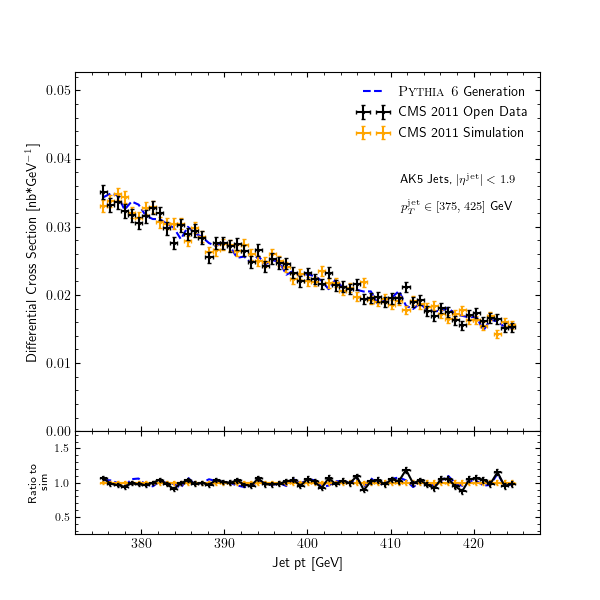

Min of the hist is :	 375.00036289704326
        
Max of the hist is : 	 424.9997116341162


In [14]:
############################
# gridspec & figsize options
gridspec_kw = {'height_ratios': (3.5, 1), 'hspace': 0.0}
figsize = (6, 6)

##############
# get subplots
nsubplots = 2
fig, axes = plt.subplots(nrows=nsubplots, gridspec_kw=gridspec_kw, figsize=figsize)

#############
# axes limits
xlim=(min(bins)-3, max(bins)+3)
ylim=(0, 1.5*np.max(cms_hist))
ylim_ratio=(0.25, 1.75)
      
for ax in axes:
    ax.set_xlim(xlim)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim_ratio)  

##########################################
# define the x-axis label and y-axis label
xlabel = r'Jet pt '
ylabel = 'Differential Cross Section'
units='GeV'
ylabel_ratio='Ratio to\nsim'

xlabel = r'{} [{}]'.format(xlabel, units)
ylabel = r'{} [{}*{}{}]'.format(ylabel, 'nb',units, r'$^{-1}$')
axes[-1].set_xlabel(xlabel)
axes[-1].set_ylabel(ylabel_ratio, fontsize=8)
axes[0].set_ylabel(ylabel)

###############
# Tick settings
for ax in axes:
    ax.minorticks_on()
    ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].tick_params(axis='y', labelsize=8)

################################################################################################
################################################################################################

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': r'\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications

stamp_x, stamp_y = 0.70, 0.70
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1)
modplot.legend(ax=axes[0], order=None)

# save plot (by default in the same directory as this notebook).
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'All-jet_pt-jec', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')


fig.show()

# Print min and max value of histogramm

print(f'''Min of the hist is :\t {alpha}
        \nMax of the hist is : \t {omega}''')

## Hardest jet pt hist

Dataframe already sorted. For duplicate lines, 1st occurence includes hard jet 

In [15]:
# For Cms
cms_hardjet = np.asarray(cms_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='first'))
cms_softjet = np.asarray(cms_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='last'))

# For Sim
sim_hardjet = np.asarray(sim_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='first'))
sim_softjet = np.asarray(sim_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='last'))

# For Gen
gen_hardjet = np.asarray(gen_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='first'))
gen_softjet = np.asarray(gen_multijetdf.drop_duplicates(subset=['rn', 'lbn', 'evn'], keep='last'))

In [16]:
# Printout of columns that exist in array

# Cms
print(cms_multijetdf.columns)

# Sim
print(sim_multijetdf.columns)

# Gen
print(gen_multijetdf.columns)

Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'index_pos', 'jet_pt',
       'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'weight'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'hard_pid', 'index_pos',
       'jet_pt', 'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'gen_jet_pt', 'gen_jet_y', 'gen_jet_phi', 'gen_jet_m',
       'gen_jet_eta', 'hard_pt', 'hard_y', 'hard_phi', 'weight', 'kfactor'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'hard_pid', 'index_pos', 'jet_pt', 'jet_y',
       'jet_phi', 'jet_m', 'jet_eta', 'hard_pt', 'hard_y', 'hard_phi',
       'weight', 'kfactor'],
      dtype='object')


## Histogramms

In [17]:
# define your histogram binning
alpha = gen_df['jet_pt'].min()
omega = gen_df['jet_pt'].max()
bins = np.linspace(alpha, omega, 40)

# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2

# which column to hist

col0 = 7
col1 = 8
col2 = 6


# cms histogram calculation
cms_hist, cms_errs, _ = calc_hist(cms_hardjet[:, col0]*cms_hardjet[:, 12], bins=bins, weights=cms_hardjet[:, -1], density=True)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = calc_hist(sim_hardjet[:, col1]*sim_hardjet[:, 13], bins=bins, weights=sim_hardjet[:,-2]*sim_hardjet[:, -1], density=True)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = calc_hist(gen_hardjet[:, col2], bins=bins, weights=gen_hardjet[:,-2]*gen_hardjet[:,-1], density=True)
gen_hist, gen_errs = gen_hist/step, gen_errs/step

<IPython.core.display.Javascript object>


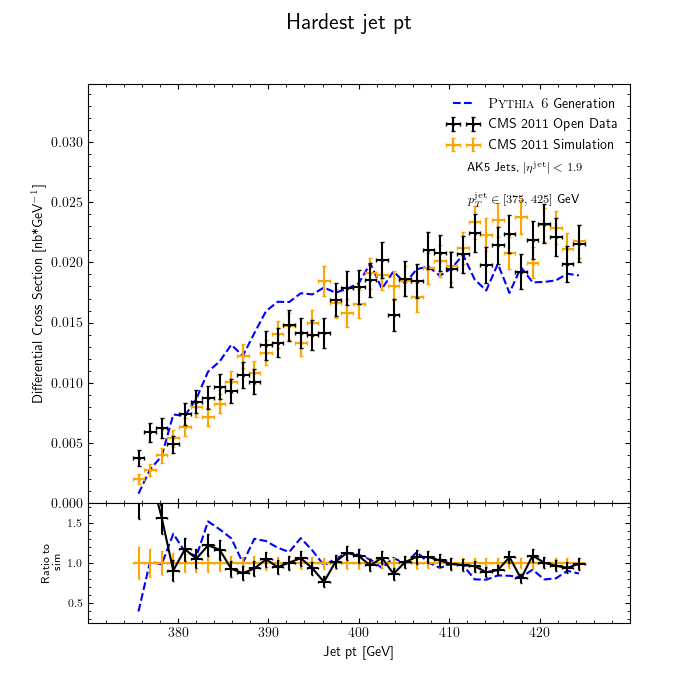

Min of the hist is :	 375.00036289704326
        
Max of the hist is : 	 424.9997116341162


In [18]:
############################
# gridspec & figsize options
gridspec_kw = {'height_ratios': (3.5, 1), 'hspace': 0.0}
figsize = (7, 7)

##############
# get subplots
nsubplots = 2
fig, axes = plt.subplots(nrows=nsubplots, gridspec_kw=gridspec_kw, figsize=figsize)

#############
# axes limits
xlim=(min(bins)-5, max(bins)+5)
ylim=(0, 1.5*np.max(cms_hist))
ylim_ratio=(0.25, 1.75)
      
for ax in axes:
    ax.set_xlim(xlim)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim_ratio)  

##########################################
# define the x-axis label and y-axis label & Titel
titel = 'Hardest jet pt'
xlabel = r'Jet pt '
ylabel = 'Differential Cross Section'
units='GeV'
ylabel_ratio='Ratio to\nsim'

xlabel = r'{} [{}]'.format(xlabel, units)
ylabel = r'{} [{}*{}{}]'.format(ylabel, 'nb', units, r'$^{-1}$')
axes[-1].set_xlabel(xlabel)
axes[-1].set_ylabel(ylabel_ratio, fontsize=8)
axes[0].set_ylabel(ylabel)

###############
# Tick settings
for ax in axes:
    ax.minorticks_on()
    ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].tick_params(axis='y', labelsize=8)

################################################################################################
################################################################################################

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': r'\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications

stamp_x, stamp_y = 0.70, 0.80
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1)
modplot.legend(ax=axes[0], order=None)

# save plot (by default in the same directory as this notebook).
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'Hard-jet_pt-jec', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')

fig.suptitle(titel, fontsize=16)
fig.show()

# Print min and max value of histogramm

print(f'''Min of the hist is :\t {alpha}
        \nMax of the hist is : \t {omega}''')

## Softer jet pt hist

In [19]:
# define your histogram binning
alpha = gen_df['jet_pt'].min()
omega = gen_df['jet_pt'].max()
bins = np.linspace(alpha, omega, 40)

# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2

# which column to hist

col0 = 7
col1 = 8
col2 = 6


# cms histogram calculation
cms_hist, cms_errs, _ = calc_hist(cms_softjet[:, col0]*cms_softjet[:, 12], bins=bins, weights=cms_softjet[:, -1], density=True)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = calc_hist(sim_softjet[:, col1]*sim_softjet[:, 13], bins=bins, weights=sim_softjet[:,-2]*sim_softjet[:, -1], density=True)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = calc_hist(gen_softjet[:, col2], bins=bins, weights=gen_softjet[:,-2]*gen_softjet[:,-1], density=True)
gen_hist, gen_errs = gen_hist/step, gen_errs/step

<IPython.core.display.Javascript object>


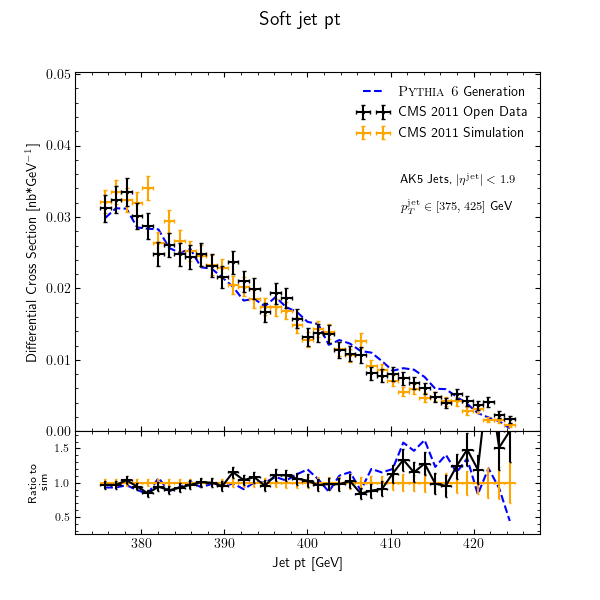

Min of the hist is :	 375.00036289704326
        
Max of the hist is : 	 424.9997116341162


In [20]:
############################
# gridspec & figsize options
gridspec_kw = {'height_ratios': (3.5, 1), 'hspace': 0.0}
figsize = (6, 6)

##############
# get subplots
nsubplots = 2
fig, axes = plt.subplots(nrows=nsubplots, gridspec_kw=gridspec_kw, figsize=figsize)

#############
# axes limits
xlim=(min(bins)-3, max(bins)+3)
ylim=(0, 1.5*np.max(cms_hist))
ylim_ratio=(0.25, 1.75)

for ax in axes:
    ax.set_xlim(xlim)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim_ratio)  

##########################################
# define the x-axis label and y-axis label & Titel
titel = 'Soft jet pt'
xlabel = r'Jet pt '
ylabel = 'Differential Cross Section'
units='GeV'
ylabel_ratio='Ratio to\nsim'

xlabel = r'{} [{}]'.format(xlabel, units)
ylabel = r'{} [{}*{}{}]'.format(ylabel, 'nb', units, r'$^{-1}$')
axes[-1].set_xlabel(xlabel)
axes[-1].set_ylabel(ylabel_ratio, fontsize=8)
axes[0].set_ylabel(ylabel)

###############
# Tick settings
for ax in axes:
    ax.minorticks_on()
    ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].tick_params(axis='y', labelsize=8)

################################################################################################
################################################################################################

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': r'\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications

stamp_x, stamp_y = 0.70, 0.70
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1)
modplot.legend(ax=axes[0], order=None)

# save plot (by default in the same directory as this notebook).
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'Soft-jet_pt-jec', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')

fig.suptitle(titel, fontsize=14)
fig.show()

# Print min and max value of histogramm

print(f'''Min of the hist is :\t {alpha}
        \nMax of the hist is : \t {omega}''')

## Calculate $\Delta\phi_{dijet} = \phi_1 - \phi_2$ and plot hist

In [21]:
cms_hardjet[:,-1]

array([7.81526072e-06, 7.81526072e-06, 7.81526072e-06, ...,
       7.81526072e-06, 7.81526072e-06, 7.81526072e-06])

In [22]:
# Cms 9 
cmsdphi = np.zeros((len(cms_hardjet), ))
for i in range(len(cmsdphi)):
    cmsdphi[i] = deltaPhi( cms_hardjet[i, 9], cms_softjet[i, 9])

# Sim 10
simdphi = np.zeros((len(sim_hardjet), ))
for i in range(len(simdphi)):
    simdphi[i] = deltaPhi( sim_hardjet[i, 10], sim_softjet[i, 10])

# Gen 8
gendphi = np.zeros((len(gen_hardjet), ))
for i in range(len(gendphi)):
    gendphi[i] = deltaPhi( gen_hardjet[i, 8], gen_softjet[i, 8])

cmsdphi = cms_hardjet[:, 9]-cms_softjet[:, 9]
simdphi = sim_hardjet[:, 10]-sim_softjet[:, 10]
gendphi = gen_hardjet[:, 8]-gen_softjet[:, 8]

In [31]:
# define your histogram binning
alpha = -4
omega = 4
bins = np.linspace(alpha, omega, 60)

# get middle bin values and step size
step = bins[1]-bins[0]
midbins = (bins[1:] + bins[:-1])/2


# cms histogram calculation
cms_hist, cms_errs, _ = calc_hist(cmsdphi, bins=bins, weights=cms_hardjet[:,-1] , density=True)
cms_hist, cms_errs = cms_hist/step, cms_errs/step

# sim histogram calculation
sim_hist, sim_errs, _ = calc_hist(simdphi, bins=bins, weights=sim_hardjet[:,-1]*sim_hardjet[:, -2] , density=True)
sim_hist, sim_errs = sim_hist/step, sim_errs/step

# gen histogram calculation
gen_hist, gen_errs, _ = calc_hist(gendphi, bins=bins, weights=gen_hardjet[:,-1]*gen_hardjet[:, -2], density=True)
gen_hist, gen_errs = gen_hist/step, gen_errs/step

<IPython.core.display.Javascript object>


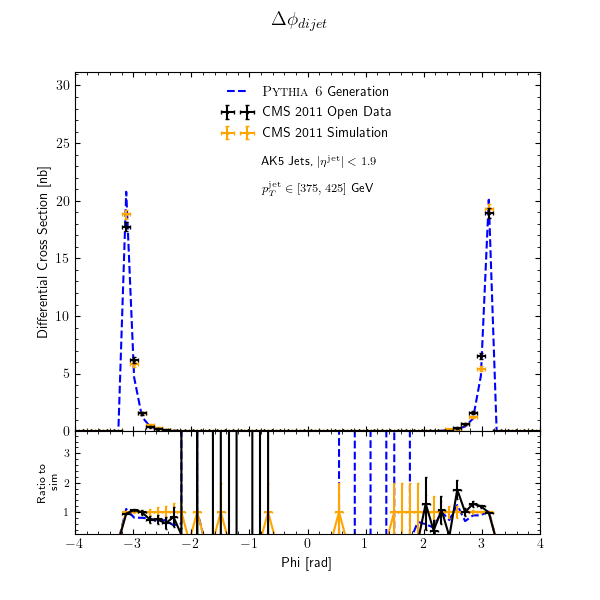

Min of the hist is :	 -4
        
Max of the hist is : 	 4


In [32]:
############################
# gridspec & figsize options
gridspec_kw = {'height_ratios': (3.5, 1), 'hspace': 0.0}
figsize = (6, 6)

##############
# get subplots
nsubplots = 2
fig, axes = plt.subplots(nrows=nsubplots, gridspec_kw=gridspec_kw, figsize=figsize)

#############
# axes limits
xlim=(min(bins), max(bins))
ylim=(0, 1.5*np.max(gen_hist))
ylim_ratio=(0.25, 3.75)
      
for ax in axes:
    ax.set_xlim(xlim)

axes[0].set_ylim(ylim)
axes[1].set_ylim(ylim_ratio)  

##########################################
# define the x-axis label and y-axis label & Titel
titel = '$\Delta\phi_{dijet}$'
xlabel = r'Phi'
ylabel = 'Differential Cross Section [nb]'
units='rad'
ylabel_ratio='Ratio to\nsim'

xlabel = r'{} [{}]'.format(xlabel, units)
ylabel = r'{}'.format(ylabel)
axes[-1].set_xlabel(xlabel)
axes[-1].set_ylabel(ylabel_ratio, fontsize=8)
axes[0].set_ylabel(ylabel)

###############
# Tick settings
for ax in axes:
    ax.minorticks_on()
    ax.tick_params(top=True, right=True, bottom=True, left=True, direction='in', which='both')

axes[0].tick_params(labelbottom=False)
axes[1].tick_params(axis='y', labelsize=8)

################################################################################################
################################################################################################

# tiny regulator
reg = 10**-30

# plot of the cms observable distribution
cms_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'black', 
             'label':'CMS 2011 Open Data'}
axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=3)
axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2, yerr=cms_errs/(sim_hist+reg), 
                **cms_style, zorder=2)

# plot of the sim observable distribution
sim_style = {'lw':1.5, 'capsize':1., 'capthick':1, 'markersize':1., 'color':'orange', 
             'label':'CMS 2011 Simulation'}
axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=2)
axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2, yerr=sim_errs/(sim_hist+reg), 
                **sim_style, zorder=1)

# plot of the gen observable distribution
gen_style = {'lw': 1.5, 'ls': '--', 'color': 'blue', 'label': r'\textsc{Pythia 6} Generation'}
axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
axes[1].plot(midbins, gen_hist/(sim_hist + reg), **gen_style, zorder=0)

# additional plot modifications

stamp_x, stamp_y = 0.40, 0.75
modplot.stamp(stamp_x, stamp_y, ax=axes[0], 
              line_0=legend_label_0, line_1=legend_label_1)

kwargs = {'loc':'upper center'}
modplot.legend(ax=axes[0], order=None, **kwargs)

# save plot (by default in the same directory as this notebook).
# The MOD logo can be optionally added by changing add_watermark to True in the following command.
modplot.save(fig, 'dijet_dphi_p_p', add_watermark=False, tx=51.5, ty=251.5, plots_dir='.')

fig.suptitle(titel, fontsize=14)
fig.show()

# Print min and max value of histogramm

print(f'''Min of the hist is :\t {alpha}
        \nMax of the hist is : \t {omega}''')

In [25]:
cms_hist.sum()

0.31579612447576844

### Check for muon pid in pfcs

In [26]:
pd.DataFrame(cms.pfcs[5], columns=cms.pfcs_cols)

,pt,y,phi,m,pid,vertex
0,0.282322,-0.728081,3.031679,0.139570,-211.0,0.0
1,0.601110,-0.420686,2.955776,0.000000,22.0,0.0
2,0.304317,-0.939851,3.367512,0.139570,-211.0,0.0
3,1.950542,-0.571951,2.984399,0.139570,211.0,0.0
4,1.393408,-0.016432,3.272649,0.000018,130.0,0.0
5,0.552492,-0.886846,3.638571,0.139570,-211.0,0.0
6,0.353035,-0.222815,3.847038,0.000000,22.0,0.0
7,1.409565,-0.412650,3.897492,0.139570,211.0,0.0
8,1.216876,-0.257380,3.850959,0.000024,22.0,0.0
9,0.815719,-0.717729,3.802221,0.139570,-211.0,1.0


In [27]:
#%%timeit 
# Use index pos column in multijet array as key for pfcs array  
ii = np.asarray(cms_multijetdf['index_pos'])
val = np.asarray([i for i in range(len(cms.pfcs))])
key = np.asarray(np.isin(val, ii))
#y = pd.DataFrame(key, columns=['t'])
#y.loc[ y['t']==True]

# Filter the pfcs array. It contains only dijet pfcs
cms_pfcs = cms.pfcs[key]

# If it contains pid=13 it means there is a muon as pfc.
# Check column 4 for pid
N = len(cms_pfcs)
ch = np.zeros((N, ))

for i in range(N):
    x = cms_pfcs[i]
    if np.any( abs(x[:, 4]) == 13 ) :  ch[i]=i

check = ch[ch !=0]
check = check.astype(int)

In [28]:
dfdf = pd.DataFrame(cms_pfcs[4], columns=cms.pfcs_cols)
dfdf.loc[ abs(dfdf['pid'])==13 ]

,pt,y,phi,m,pid,vertex
41,5.408559,0.887183,1.397656,0.1057,13.0,0.0


In [29]:
print(cms_df.columns)
print(sim_df.columns)
print(gen_df.columns)

Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'index_pos', 'jet_pt',
       'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'weight'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'npv', 'quality', 'hard_pid', 'index_pos',
       'jet_pt', 'jet_y', 'jet_phi', 'jet_m', 'jet_eta', 'jec', 'jet_area',
       'jet_max_nef', 'gen_jet_pt', 'gen_jet_y', 'gen_jet_phi', 'gen_jet_m',
       'gen_jet_eta', 'hard_pt', 'hard_y', 'hard_phi', 'weight', 'kfactor'],
      dtype='object')
Index(['fn', 'rn', 'lbn', 'evn', 'hard_pid', 'index_pos', 'jet_pt', 'jet_y',
       'jet_phi', 'jet_m', 'jet_eta', 'hard_pt', 'hard_y', 'hard_phi',
       'weight', 'kfactor'],
      dtype='object')


In [30]:
sim_hardjet[:, -1]

array([1.42628562, 1.23186095, 1.59709732, ..., 1.81088825, 1.7199806 ,
       0.61514429])